# Storage of Network Data and Topology

As discussed in the first tutorial, OpenPNM uses Numpy ``ndarrays`` to store all data, and these arrays each stored in ``dict``s, because all OpenPNM objects are subclassed python dictionaries. In this tutorial will take a deper dive into the details of the OpenPNM data storage scheme. The sections to be covered are:

| Subject |
| :- |
| The Spreadsheet Analogy |
| Maintaining Data Integrity |
| Representing Topology |

## Spreadsheet Analogy

The best analogy for explaining data storage in OpenPNM is the humble spreadsheet.  According to this analogy you can imagine all data is stored in a table; two tables actually, one for pore data and one for throat data.  Each pore (or throat) corresponds to a row and each property corresponds to a column.  Consider the following network with 4 pores, 3 throats:

In [43]:
import openpnm as op
import numpy as np
np.random.seed(0)
pn = op.network.Demo(shape=[4, 1, 1])

Let's use ``pandas`` to express the geometric properties as a 'spreadsheet' and pull out all pore properties that are are a single column wide

In [44]:
import pandas as pd
pore_data_sheet = pd.DataFrame({k: pn[k] for k in pn.props(element='pore') if pn[k].ndim == 1})

We can now view this 'spreadsheet':

In [47]:
pore_data_sheet

,pore.coordination_number,pore.diameter,pore.max_size,pore.seed,pore.volume
0,1.0,0.474407,1.0,0.474407,0.055905
1,2.0,0.557595,1.0,0.557595,0.090773
2,2.0,0.501382,1.0,0.501382,0.065994
3,1.0,0.472442,1.0,0.472442,0.055213


The column names are the properties such as **pore.volume**, and the rows correspond to the pore index, so pore ``0`` has a volume of 0.055905.  

One could also extract an entire column using:

In [50]:
column = pore_data_sheet['pore.volume']
print(column)

0    0.055905
1    0.090773
2    0.065994
3    0.055213
Name: pore.volume, dtype: float64


Or access individual elements:

In [51]:
print(pore_data_sheet['pore.volume'][0])

0.05590507143096387


> ⚠ **Warning**
>
> The spreadsheet analogy is very apt, but it breaks down slightly when one considers data that is multiple colums wide such as 'pore.coords'.  The is stored as an Np-by-3 array in the network dictionary, but spreadsheets usually require that all data is only a single column wide. 

### Rules to Maintain Data Integrity

Several rules have been implemented to control the integrity of the data:

#### All Values are Converted to Numpy Arrays
Only Numpy arrays can be stored in an OpenPNM object, and any data that is written into one of the OpenPNM object dicionaries will be converted to a Numpy array.  This is done to ensure that all mathematically operations throughout the code can be consistently done using vectorization.  Note that any subclasses of Numpy arrays, such as Dask arrays or Unyt arrays are also acceptable.

In [9]:
pn['throat.list'] = [1, 2, 3]
print(type(pn['throat.list']))

<class 'numpy.ndarray'>


This illustrates that the basic python list-type has been converted to a Numpy array when stored in the dictionary

#### Any Scalars are Expanded to a Full-Length Vector
For the sake of consistency only arrays of length *Np* or *Nt* are allowed in the dictionary. Assigning a scalar value to a dictionary results in the creation of a full length vector, either *Np* or *Nt* long, depending on the name of the array..  This effectively applies the scalar value to all locations in the network.**

In [10]:
pn['pore.test'] = 0
print(pn['pore.test'])

[0 0 0 0]


Note how the scalar value has been cast to an array of 4 elements long, one for each pore in the network. 

#### Dictionary Keys Must Start With 'pore' or 'throat'
All array names must begin with either *'pore.'* or *'throat.'* which serves to identify the type of information they contain.

In [11]:
try:
    pn['foo.bar'] = 0
except:
    print('This will throw an exception since the dict name cannot start with foo')

This will throw an exception since the dict name cannot start with foo


#### Nesting Dictionary Names are Allowed
It's possible to create nested properties by assigning a dictionary containing numpy arrays

In [12]:
pn['pore.concentration'] = {'species_A': 0, 'species_B': 1}
print(pn['pore.concentration'])

{'species_A': array([0, 0, 0, 0]), 'species_B': array([1, 1, 1, 1])}


The above rule about expanding the scalar values to a numpy array have been applied.  

Requesting the top level of dictionary key returns both concentrations, but they can accessed directly too:

In [13]:
print(pn['pore.concentration.species_A'])

[0 0 0 0]


You can also retreive a dictionary by requesting only the element ('pore' or 'throat') and the propname ('concentration'):

In [16]:
pn['pore.concentration']

{'species_A': array([0, 0, 0, 0]), 'species_B': array([1, 1, 1, 1])}

The above retuns a 'subdictionary' which can be indexed into:

In [17]:
pn['pore.concentration']['species_A']

array([0, 0, 0, 0])

#### Boolean Arrays are Treated as Labels
Any Boolean data will be treated as a *label* while all other numerical data is treated as a *property*.

In [18]:
pn['pore.label'] = False
print(pn.labels(element='pore'))

['pore.all', 'pore.label', 'pore.left', 'pore.right', 'pore.surface']


You can see that ``'pore.label'`` shows up in this list automatically since it is of Boolean type. 

The rules for writing data also apply, so you can create a new label using:

In [19]:
pn['pore.new_label'] = False
pn['pore.new_label'][[0, 1, 2]] = True
print(pn.pores('new_label'))

[0 1 2]


#### Dictionary Keys with a Leading Underscore are Hidden
Following the Python convention, if a piece of data is not really meant to be seen or used by the user, it can be pre-pended with an underscore and it will no appear in any output.

In [20]:
pn['pore._hidden'] = 1
print(pn.props())

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     : pore.concentration.species_A
2     : pore.concentration.species_B
3     : pore.coordination_number
4     : pore.coords
5     : pore.diameter
6     : pore.max_size
7     : pore.seed
8     : pore.test
9     : pore.volume
10    : throat.conns
11    : throat.cross_sectional_area
12    : throat.diameter
13    : throat.diffusive_size_factors
14    : throat.hydraulic_size_factors
15    : throat.length
16    : throat.list
17    : throat.max_size
18    : throat.spacing
19    : throat.volume
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


The ``'pore._hidden'`` key does not show up in this list, though it is present:

In [21]:
pn['pore._hidden']

array([1, 1, 1, 1])

In [23]:
print('pore._hidden' in pn.keys())

True


## Representing Topology

Consider the following simple random network:

In [24]:
np.random.seed(10)
pts = np.random.rand(5, 2)*1.5
pn = op.network.Delaunay(points=pts, shape=[1, 1, 0])

ValueError: operands could not be broadcast together with shapes (5,2) (3,) 

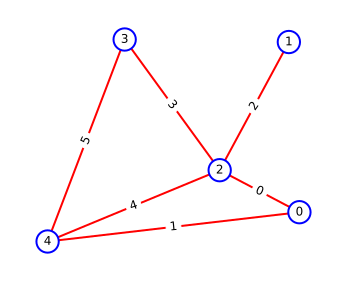

In [23]:
op.topotools.plot_tutorial(pn)

The basic premise of how OpenPNM stores topology can be stated in 1 sentence:

**The pores on either end of a throat are just another property to be stored, along with diameter, length, etc.**

In other words, referring to the above diagram, throat No. 5 has pores 3 and 4 on it's ends.  Using the spreadsheet analogy, this implies a new colunm that stores the pair of pores connected by each throat.  OpenPNM calls this property ``'throat.conns'``: 

In [24]:
print(pn['throat.conns'])

[[0 2]
 [0 4]
 [1 2]
 [2 3]
 [2 4]
 [3 4]]


Inspection of this *Nt-by-2* array shows that each row contains the pore indices corresponding to that throat.

### Sparse Adjacency Matrices

The topology storage scheme described above is actually an [adjacency matrix](http://en.wikipedia.org/wiki/Adjacency_matrix), in a [sparse storage format](http://en.wikipedia.org/wiki/Sparse_matrix) known as IJV or COO.  

An adjacency matrix is a *Np*-by-*Np* matrix with non-zero values at location (*i*, *j*) indicating that pores *i* and *j* are connected.  

An important feature of the adjacency matrix is that it is highly sparse (mostly zeros) and can be stored with a variety of [sparse storage schemes](https://docs.scipy.org/doc/scipy/reference/sparse.html) offered by Scipy.  OpenPNM stores the adjacency matrix in the 'COO' format, which essentially stores the coordinates (I,J) of the nonzero elements in an two-colume wide array.

Thus the throat property called ``'throat.conns'`` is an *Nt*-by-2 array that gives the index of the two pores on either end of a given throat.  

#### Additional Thoughts on Sparse Storage

* In pore networks there is (usually) no difference between traversing from pore *i* to pore *j* or from pore *j* to pore *i*, so a 1 is also found at location (*j*, *i*) and the matrix is symmetrical.

* Since the adjacency matrix is symmetric, it is redundant to store the entire matrix when only the upper triangular part is necessary.  The ``'throat.conns'`` array only stores the upper triangular information, and *i* is always less than *j*.

* Although this storage scheme is widely known as *IJV*, the ``scipy.sparse`` module calls this the Coordinate or *COO* storage scheme.

* Some tasks are best performed on other types of storages scheme, such as *CSR* or *LIL*.  OpenPNM converts between these internally as necessary, but users can generate a desired format using the ``create_adjacency_matrix`` method which accepts the storage type as an argument (i.e. ``'csr'``, ``'lil'``, etc).  For a discussion of sparse storage schemes and the respective merits, see this [Wikipedia article](http://en.wikipedia.org/wiki/Sparse_matrix).

### Topology Rules

The only topology definitions required by OpenPNM are:

1. A throat connects exactly two pores, no more and no less

2. Throats are non-directional, meaning that flow in either direction is equal

Other general, but non-essential rules are:

3. Pores can have an arbitrary number of throats, including zero; however, pores with zero throats lead to singular matrices and other problems so should be avoided.

4. Two pores are generally connected by no more than one throat.  It is technically possible in OpenPNM to have multiple throats between a pair of pores, but it is not rigorosly supported so unintended results may arise.

### Historical Aside
During the development of OpenPNM, it was debated whether existing Python graph theory packages (such as [graph-tool](http://graph-tool.skewed.de/) or [NetworkX](http://networkx.github.io/)) should be used to store the network topology.  It was decided that network property data should be simply stored as [Numpy ND-arrays](http://www.numpy.org/) as discussed above for the primary reason that this format makes the data storage very transparent and familiar since all engineers are used to working with arrays (i.e. vectors), and also very efficiently since this allows code vectorization.  Fortuitously, around the same time as this discussion, Scipy introduced the [compressed sparse graph library](http://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html), which contains numerous graph theory algorithms that take Numpy arrays as arguments.  Therefore, OpenPNM's topology model is implemented using Numpy arrays, leveraging the ``scipy.sparse.csgraph`` library. Most importantly, this approach is perfectly in tune with the 'spreadsheet' model of data storage.